# ==================================================
#
#       Map the California and PNW Reservoirs
#
# ===================================================

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import cartopy.io.shapereader as shpreader
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import calendar
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np

In [10]:
# ------------------------------------------------------------
#    Function to plot a color bar 
# ------------------------------------------------------------

# NOTE - the line doesn't s how up with a layer has a zorder > 1

def scale_bar(ax, length, utm_zone, adjx, adjy, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    """
    #Projection in metres, need to change this to suit your own figure
    utm = ccrs.UTM(utm_zone)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    #Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    sbcx = sbcx + adjx  #I added adjx to adjust left or right
    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * 500, sbcx + length * 500 ] 
    #Plot the scalebar
    ax.plot(bar_xs, [sbcy, sbcy+adjy], transform=utm, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbcx, sbcy+(adjy/2), str(length) + ' km', transform=utm,
            horizontalalignment='center', verticalalignment='bottom')

In [11]:
# ------------------------------------------------------------
#           Upload California Reservoir Information
# ------------------------------------------------------------

# ---------- stations - all of them ---------------------
file_temp = '/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/CA_reservoir_stations_initial.csv'
station_i = pd.read_csv(file_temp)

# -------- stations with reservoir elevation ----------
res_stations = pd.read_csv('/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/CA_reservoir_stations.csv')
res_stations.columns = ['site_no']

In [12]:
# ------------------------------------------------------------
#           Upload PNW Reservoir Information
# ------------------------------------------------------------

lat_lon_pnw = pd.read_csv('/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/misc/latlon_reservoirs.csv')
lat_lon_pnw.columns = (['site_id','lat','lon'])

# --------------------------------------------------
#   Process California Reservoir data (get only reservoir sites)
# --------------------------------------------------

In [13]:
# -------------------------
#   Loop to extract station ID from URL
# -----------------------

ID_url_list = pd.DataFrame()
for urlx in station_i.meta_url[:]:
    myString = str(urlx)
    pos1 = myString.index('station_id=')
    idx = myString[pos1+11:]
    idx = pd.DataFrame([idx])
    idx = idx.transpose()
    ID_url_list = ID_url_list.append(idx)
indexx = list(range(1,len(ID_url_list)+1,1))
ID_url_list = ID_url_list.set_index([indexx])
ID_url_list.columns = ['station_id']

In [14]:
# -------------------------
#   Loop to match reservoir IDs with URL IDs
# -----------------------

ID_list = pd.DataFrame()
id_list = list(ID_url_list.station_id)
for idxi in res_stations['site_no']:
    indexi = id_list.index(idxi)
    #indexi = which(idxi == ID_url_list.station_id[:])
    indexi = pd.DataFrame([indexi])
    indexi = indexi.transpose()
    ID_list = ID_list.append(indexi)
indexx = list(range(1,len(ID_list)+1,1))
ID_list = ID_list.set_index([indexx])
ID_list.columns = ['index_val']

In [15]:
# -------------------------
#  Get lat/lon of sites, and make lon negative
# -----------------------
latx = np.array(station_i.lat)
lonx = np.array(station_i.lon)

latx = latx[ID_list.index_val[:]]
latx = latx.astype(float)
lonx = lonx[ID_list.index_val[:]]
lonx = lonx.astype(float)
lonx = lonx*(-1)

namex = np.array(station_i.name)
namex = namex[ID_list.index_val[:]]

# -------------- get a data frame with lat, lon, site abbreviation (code), and site name ----------

latxi = list(latx)
lonxi = list(lonx)
namex = list(namex)
res_stations2 = pd.DataFrame(res_stations) 
res_stations2['lat'] = pd.Series(latxi, index=res_stations2.index)
res_stations2['lon'] = pd.Series(lonxi, index=res_stations2.index)
res_stations2['name'] = pd.Series(namex, index=res_stations2.index)

# ------------ just write data with names -------
#res_stations2.to_csv('/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/merged_data/reservoir_stations.csv', index=False)

In [35]:
# ================================================================================================
#    CA: list with bureau of reclamation site IDs and burea of rec, USGS, and NorWest IDs
# ================================================================================================

flow_path = '/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/merged_data/'

# DATA ORDER: reservoir name, resrvoir code, upstream gauge 1, upstream gauge 2, upstream gauge 3, downstream gauge 1, downstream gauge 2, downstream gauge 3
#              First series of data is USGS, second is NorWest
# NOTE: gagues #1 are closest to reservoir, #2 is next closest, etc. (so #3 upstream is most upstream, #3 is furthest downstream)

# ------------------ read csv ----------
CA_reservoir_info = pd.read_csv(flow_path  + 'CA_USGS_NorWest.csv') 
CA_reservoir_info2 = CA_reservoir_info.sort(['site_code'])
CA_reservoir_info2.set_index(res_stations2.index)

/home/rniemeyr/anaconda/envs/cartopy/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [47]:
datax = CA_reservoir_info2.ix[1][colx]
print(datax)

upstream1_USGS              NaN
upstream2_USGS              NaN
upstream3_USGS              NaN
downstream1_USGS    1.15255e+07
downstream2_USGS    1.15257e+07
downstream3_USGS            NaN
upstream1_NW              29456
upstream2_NW              28886
upstream3_NW              28824
downstream1_NW            28901
downstream2_NW            28971
downstream3_NW            28285
Name: 1, dtype: object


True

In [67]:

# -------------------------
#  Extract only reservoirs with data
# -----------------------

colx = ['upstream1_USGS', 'upstream2_USGS', 'upstream3_USGS',
       'downstream1_USGS', 'downstream2_USGS', 'downstream3_USGS',
       'upstream1_NW', 'upstream2_NW', 'upstream3_NW', 'downstream1_NW',
       'downstream2_NW', 'downstream3_NW']

res_stations3 = pd.DataFrame()
res_no_data = pd.DataFrame()
i = -1
for res_code in res_stations2.site_no:
    i = i + 1
    datax = CA_reservoir_info2.ix[i][colx]
    x = datax>0 
    
    # ---------- reservoirs with USGS or NorWest data -------
    if any(x==True):
        res_stations3 = res_stations3.append(res_stations2.ix[i])
        
    # ------------- reservoirs with no USGS nor NorWest data ------
    else:
        res_no_data = res_no_data.append(res_stations2.ix[i])
 

In [68]:
# ------------ just write data with names -------#
#res_stations3.to_csv('/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/merged_data/CA_reservoir_stations_with_data.csv', index=False)

In [73]:
type(res_stations3['lon'])

pandas.core.series.Series

In [71]:
type(lat_lon_pnw['lat'])

pandas.core.series.Series

# ------------------------------------------------
#  Plot the Maps
# -------------------------------------------------

/home/rniemeyr/anaconda/envs/cartopy/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


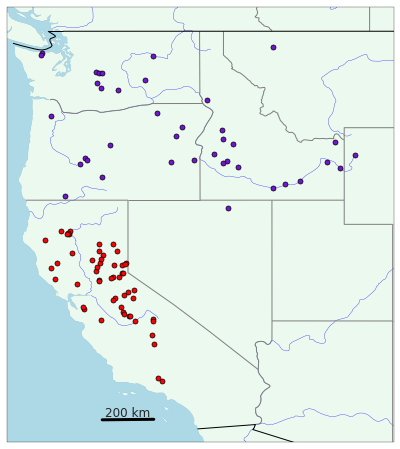

In [75]:
fig = plt.figure(figsize=(15,8))

def main():
    ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.set_extent([-90, -80, 34, 38]) # TVA area
    ax.set_extent([-125, -109, 32, 50])  # California

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    rivers_lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='50m',
        facecolor='none')
    
    country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',
        facecolor='gray')

    ocean = cfeature.NaturalEarthFeature(
        category='physical',
        name='ocean',
        scale='50m',
        facecolor='blue')
        
    #ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(land,facecolor='#ECF9EF', zorder = 1)
    ax.add_feature(states_provinces, edgecolor='gray', zorder = 3, linewidth = 1)
    ax.add_feature(country_borders, edgecolor='black', zorder = 3, linewidth = 1)
    ax.add_feature(ocean,facecolor='lightblue', zorder = 1)
    ax.add_feature(rivers_lakes, edgecolor='blue')
    
    plt.plot(res_stations3['lon'], res_stations3['lat'],'s',zorder=4, markersize=5,markeredgewidth=0.7,
             marker='o',markeredgecolor='black', color='red')
    plt.plot(lat_lon_pnw['lon'], lat_lon_pnw['lat'],'s',zorder=4, markersize=5,markeredgewidth=0.7,
             marker='o',markeredgecolor='black', color='#7514D5')

    scale_bar(ax, 200, 10, 0, 8000) # adjx adjy
    #scale_bar(ax, 200, 10, 100000, 10000)
    
    plt.show()


if __name__ == '__main__':
    main()



/home/rniemeyr/anaconda/envs/cartopy/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


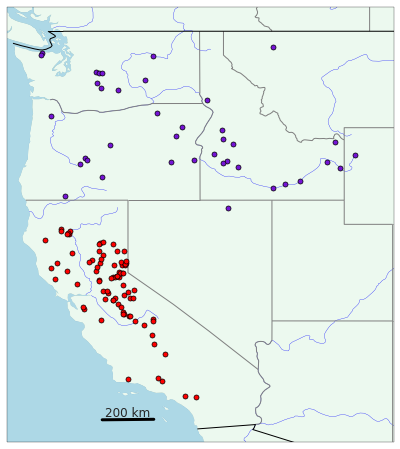

In [76]:
fig = plt.figure(figsize=(15,8))

def main():
    ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.set_extent([-90, -80, 34, 38]) # TVA area
    ax.set_extent([-125, -109, 32, 50])  # California

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    rivers_lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='50m',
        facecolor='none')
    
    country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',
        facecolor='gray')

    ocean = cfeature.NaturalEarthFeature(
        category='physical',
        name='ocean',
        scale='50m',
        facecolor='blue')
        
    #ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(land,facecolor='#ECF9EF', zorder = 1)
    ax.add_feature(states_provinces, edgecolor='gray', zorder = 3, linewidth = 1)
    ax.add_feature(country_borders, edgecolor='black', zorder = 3, linewidth = 1)
    ax.add_feature(ocean,facecolor='lightblue', zorder = 1)
    ax.add_feature(rivers_lakes, edgecolor='blue')
    
    plt.plot(res_stations2['lon'], res_stations2['lat'],'s',zorder=4, markersize=5,markeredgewidth=0.7,
             marker='o',markeredgecolor='black', color='red')
    plt.plot(lat_lon_pnw['lon'], lat_lon_pnw['lat'],'s',zorder=4, markersize=5,markeredgewidth=0.7,
             marker='o',markeredgecolor='black', color='#7514D5')

    scale_bar(ax, 200, 10, 0, 8000) # adjx adjy
    #scale_bar(ax, 200, 10, 100000, 10000)
    
    plt.show()


if __name__ == '__main__':
    main()



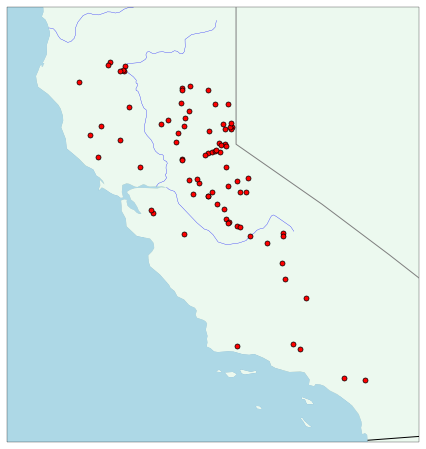

/home/rniemeyr/anaconda/envs/cartopy/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


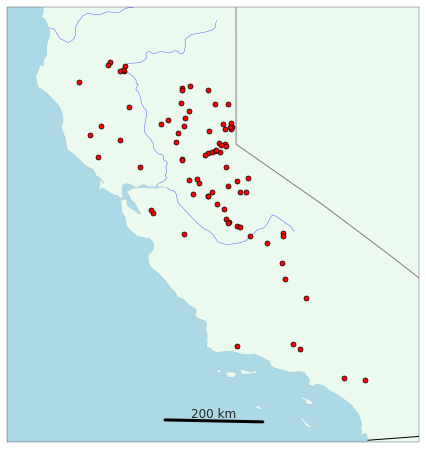

In [17]:
fig = plt.figure(figsize=(15,8))

ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-125, -109, 32, 50])  # Western US (all sites)
ax.set_extent([-125, -116, 32.5, 42])  # California

# Put a background image on for nice sea rendering.
ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

rivers_lakes = cfeature.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='50m',
    facecolor='none')

country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='50m',
    facecolor='none')

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='gray')

ocean = cfeature.NaturalEarthFeature(
    category='physical',
    name='ocean',
    scale='50m',
    facecolor='blue')

#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(land,facecolor='#ECF9EF', zorder = 1)
ax.add_feature(states_provinces, edgecolor='gray', zorder = 3, linewidth = 1)
ax.add_feature(country_borders, edgecolor='black', zorder = 3, linewidth = 1)
ax.add_feature(ocean,facecolor='lightblue', zorder = 1)
ax.add_feature(rivers_lakes, edgecolor='blue')


plt.plot(lonx, latx,'s',zorder=4, markersize=5,markeredgewidth=0.7,
         marker='o',markeredgecolor='black', color='red')
plt.plot(lat_lon_pnw['lon'], lat_lon_pnw['lat'],'s',zorder=4, markersize=5,markeredgewidth=0.7,
         marker='o',markeredgecolor='black', color='#7514D5')

scale_bar(ax, 200, 10, 0, 0)

    
plt.show()

/home/rniemeyr/anaconda/envs/cartopy/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


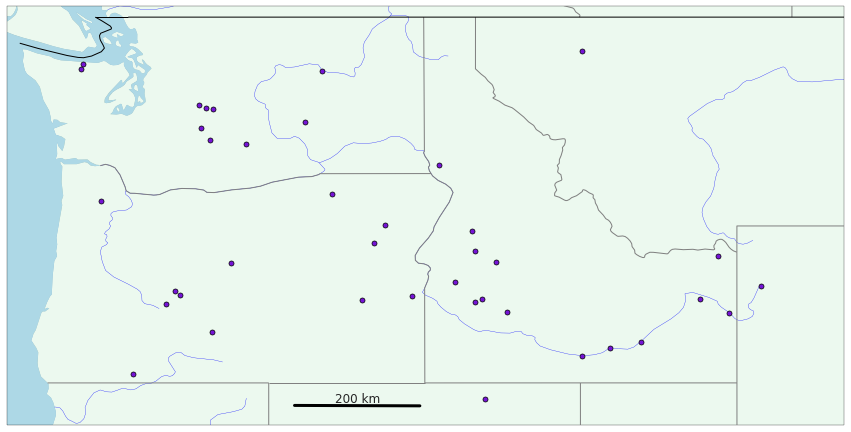

In [18]:
fig = plt.figure(figsize=(15,8))

ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-125, -109, 32, 50])  # Western US (all sites)
ax.set_extent([-125, -116, 32.5, 42])  # California
ax.set_extent([-125, -109, 41.2, 49.2])  # California

# Put a background image on for nice sea rendering.
ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

rivers_lakes = cfeature.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='50m',
    facecolor='none')

country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='50m',
    facecolor='none')

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='gray')

ocean = cfeature.NaturalEarthFeature(
    category='physical',
    name='ocean',
    scale='50m',
    facecolor='blue')

#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(land,facecolor='#ECF9EF', zorder = 1)
ax.add_feature(states_provinces, edgecolor='gray', zorder = 3, linewidth = 1)
ax.add_feature(country_borders, edgecolor='black', zorder = 3, linewidth = 1)
ax.add_feature(ocean,facecolor='lightblue', zorder = 1)
ax.add_feature(rivers_lakes, edgecolor='blue')


plt.plot(lonx, latx,'s',zorder=4, markersize=5,markeredgewidth=0.7,
         marker='o',markeredgecolor='black', color='red')
plt.plot(lat_lon_pnw['lon'], lat_lon_pnw['lat'],'s',zorder=4, markersize=5,markeredgewidth=0.7,
         marker='o',markeredgecolor='black', color='#7514D5')

scale_bar(ax, 200, 10, 100000, 10000)

    
plt.show()

/home/rniemeyr/anaconda/envs/cartopy/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


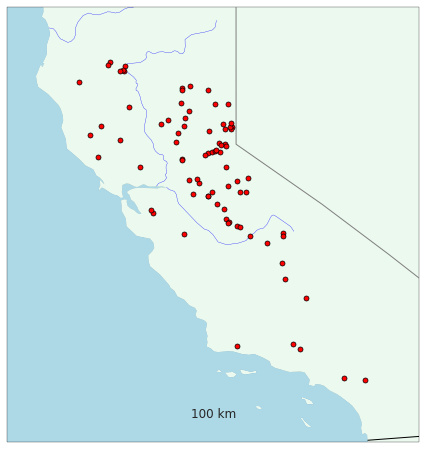

In [21]:
fig = plt.figure(figsize=(15,8))

def main():
    ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.set_extent([-125, -109, 32, 50])  # Western US (all sites)
    ax.set_extent([-125, -116, 32.5, 42])  # California

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    rivers_lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='50m',
        facecolor='none')
    
    country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',
        facecolor='gray')

    ocean = cfeature.NaturalEarthFeature(
        category='physical',
        name='ocean',
        scale='50m',
        facecolor='blue')
        
    #ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(land,facecolor='#ECF9EF', zorder = 1)
    ax.add_feature(states_provinces, edgecolor='gray', zorder = 3, linewidth = 1)
    ax.add_feature(country_borders, edgecolor='black', zorder = 3, linewidth = 1)
    ax.add_feature(ocean,facecolor='lightblue', zorder = 2)
    ax.add_feature(rivers_lakes, edgecolor='blue')

    
    plt.plot(lonx, latx,'s',zorder=4, markersize=5,markeredgewidth=0.7,
             marker='o',markeredgecolor='black', color='red')
    plt.plot(lat_lon_pnw['lon'], lat_lon_pnw['lat'],'s',zorder=4, markersize=5,markeredgewidth=0.7,
             marker='o',markeredgecolor='black', color='#7514D5')

    scale_bar(ax, 100, 10, 0, 0)
    plt.show()


if __name__ == '__main__':
    main()



In [ ]:
/raid3/rniemeyr/RBM/data/reservoirs/GRanD


# ------------------------------------------------------------------------
#   Map out site and list site names (to get upstream and downstream)
# ------------------------------------------------------------------------

In [9]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

/home/rniemeyr/anaconda/envs/cartopy/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


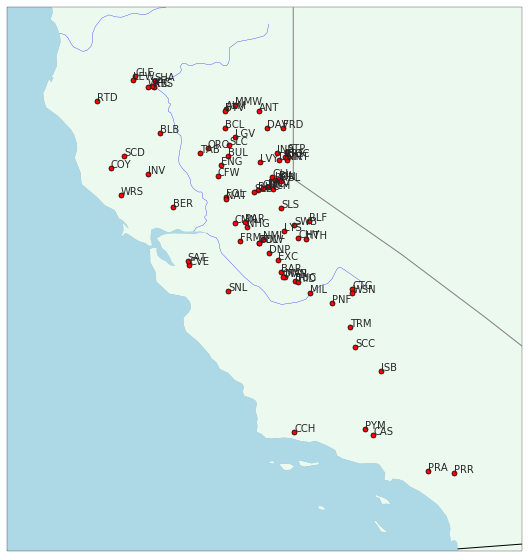

In [124]:

fig = plt.figure(figsize=(15,10))

y1 = 42
y2 = 32.5
x1 = -116
x2 = -125


def main():
    ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.set_extent([-125, -109, 32, 50])  # Western US (all sites)
    #ax.set_extent([-125, -116, 32.5, 42])  # California
    ax.set_extent([x1, x2, y1, y2])  # California

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    rivers_lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='50m',
        facecolor='none')
    
    country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',
        facecolor='gray')

    ocean = cfeature.NaturalEarthFeature(
        category='physical',
        name='ocean',
        scale='50m',
        facecolor='blue')
        
    #ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(land,facecolor='#ECF9EF', zorder = 1)
    ax.add_feature(states_provinces, edgecolor='gray', zorder = 3, linewidth = 1)
    ax.add_feature(country_borders, edgecolor='black', zorder = 3, linewidth = 1)
    ax.add_feature(ocean,facecolor='lightblue', zorder = 2)
    ax.add_feature(rivers_lakes, edgecolor='blue')

    
    plt.plot(lonx, latx,'s',zorder=4, markersize=5,markeredgewidth=0.7,
             marker='o',markeredgecolor='black', color='red')
    
    
    for i in range(0,len(lonx)):
        plt.text(lonx[i], latx[i], str(res_stations2.site_no[i]), fontsize = 10, zorder=10)
                
    plt.show()


if __name__ == '__main__':
    main()



/home/rniemeyr/anaconda/envs/cartopy/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


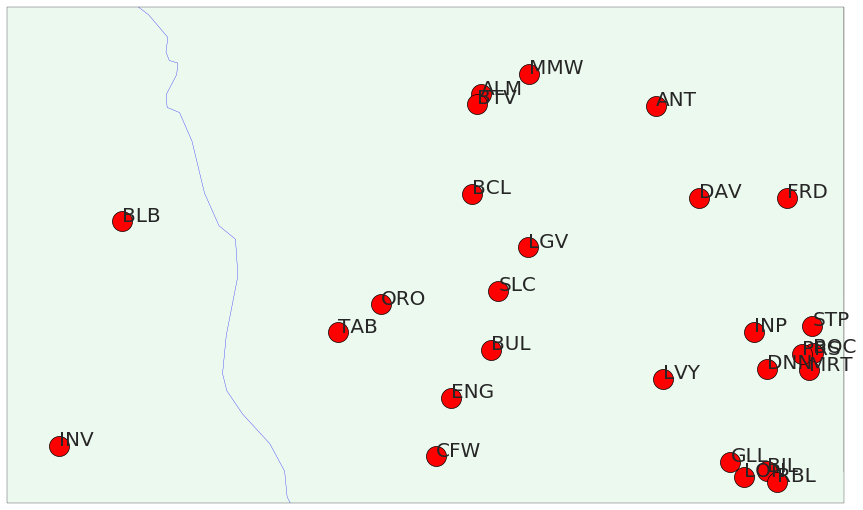

In [29]:

fig = plt.figure(figsize=(15,10))

y1 = 38.9
y2 = 40.5
x1 = -122.7
x2 = -120.0


def main():
    ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.set_extent([-125, -109, 32, 50])  # Western US (all sites)
    #ax.set_extent([-125, -116, 32.5, 42])  # California
    ax.set_extent([x1, x2, y1, y2])  # California

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    rivers_lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='50m',
        facecolor='none')
    
    country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',
        facecolor='gray')

    ocean = cfeature.NaturalEarthFeature(
        category='physical',
        name='ocean',
        scale='50m',
        facecolor='blue')
        
    #ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(land,facecolor='#ECF9EF', zorder = 1)
    ax.add_feature(states_provinces, edgecolor='gray', zorder = 3, linewidth = 1)
    ax.add_feature(country_borders, edgecolor='black', zorder = 3, linewidth = 1)
    ax.add_feature(ocean,facecolor='lightblue', zorder = 2)
    ax.add_feature(rivers_lakes, edgecolor='blue')

    
    plt.plot(lonx, latx,'s',zorder=4, markersize=20,markeredgewidth=0.7,
             marker='o',markeredgecolor='black', color='red')
    
    for i in range(0,len(lonx)):
        if (lonx[i] > x1 and lonx[i] < x2):
            if (latx[i] > y1 and latx[i] < y2):
                plt.text(lonx[i], latx[i], str(res_stations2.site_no[i]), fontsize = 20, zorder=10)
                
    plt.show()


if __name__ == '__main__':
    main()



/home/rniemeyr/anaconda/envs/cartopy/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


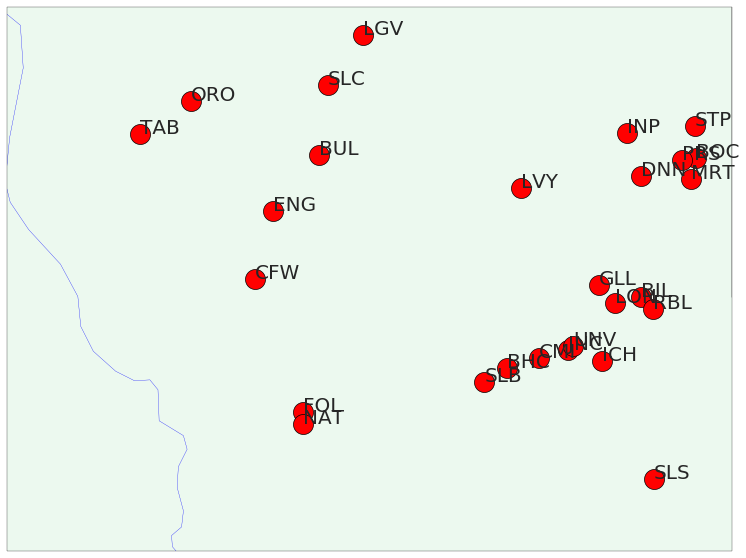

In [20]:

fig = plt.figure(figsize=(15,10))

y1 = 38.3
y2 = 39.8
x1 = -122.
x2 = -120.


def main():
    ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.set_extent([-125, -109, 32, 50])  # Western US (all sites)
    #ax.set_extent([-125, -116, 32.5, 42])  # California
    ax.set_extent([x1, x2, y1, y2])  # California

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    rivers_lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='50m',
        facecolor='none')
    
    country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',
        facecolor='gray')

    ocean = cfeature.NaturalEarthFeature(
        category='physical',
        name='ocean',
        scale='50m',
        facecolor='blue')
        
    #ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(land,facecolor='#ECF9EF', zorder = 1)
    ax.add_feature(states_provinces, edgecolor='gray', zorder = 3, linewidth = 1)
    ax.add_feature(country_borders, edgecolor='black', zorder = 3, linewidth = 1)
    ax.add_feature(ocean,facecolor='lightblue', zorder = 2)
    ax.add_feature(rivers_lakes, edgecolor='blue')

    
    plt.plot(lonx, latx,'s',zorder=4, markersize=20,markeredgewidth=0.7,
             marker='o',markeredgecolor='black', color='red')
    
    for i in range(0,len(lonx)):
        if (lonx[i] > x1 and lonx[i] < x2):
            if (latx[i] > y1 and latx[i] < y2):
                plt.text(lonx[i], latx[i], str(res_stations2.site_no[i]), fontsize = 20, zorder=10)
                
    plt.show()


if __name__ == '__main__':
    main()



In [115]:
print_full(res_stations2)

   site_no      lat       lon                             name
0      ALM  40.2180 -121.1730                     LAKE ALMANOR
1      ANT  40.1800 -120.6070                    ANTELOPE LAKE
2      BAR  37.3670 -120.2170                             BEAR
3      BCL  39.8970 -121.2020               BUCKS LAKE STORAGE
4      BER  38.5130 -122.1040                        BERRYESSA
5      BHC  38.8050 -120.6200               BRUSH CREEK (SMUD)
6      BIL  39.0010 -120.2500                 BUCK ISLAND LAKE
7      BLB  39.8080 -122.3290                      BLACK BUTTE
8      BOC  39.3830 -120.1000                   BOCA RESERVOIR
9      BTV  40.1870 -121.1860                      BUTT VALLEY
10     BUC  37.2130 -119.9700                     BUCHANAN DAM
11     BUL  39.3930 -121.1400                 NEW BULLARDS BAR
12     CAS  34.5170 -118.6000                          CASTAIC
13     CCH  34.5830 -119.9800                     CACHUMA LAKE
14     CFW  39.0500 -121.3170  BEAR RIVER AT CAMP FAR W

In [56]:
# -------------------------
#   Loop to extract station ID from URL
# -----------------------

ID_url_list = pd.DataFrame()
for urlx in station_i.meta_url[:]:
    myString = str(urlx)
    pos1 = myString.index('station_id=')
    idx = myString[pos1+11:]
    idx = pd.DataFrame([idx])
    idx = idx.transpose()
    ID_url_list = ID_url_list.append(idx)
indexx = list(range(1,len(ID_url_list)+1,1))
ID_url_list = ID_url_list.set_index([indexx])
ID_url_list.columns = ['station_id']

# -------------------------
#   Loop to match reservoir IDs with URL IDs
# -----------------------

ID_list = pd.DataFrame()
id_list = list(ID_url_list.station_id)
for idxi in res_stations['site_no']:
    indexi = id_list.index(idxi)
    #indexi = which(idxi == ID_url_list.station_id[:])
    indexi = pd.DataFrame([indexi])
    indexi = indexi.transpose()
    ID_list = ID_list.append(indexi)
indexx = list(range(1,len(ID_list)+1,1))
ID_list = ID_list.set_index([indexx])
ID_list.columns = ['index_val']

In [64]:
# -------------------------
#  Get lat/lon of sites, and make lon negative
# -----------------------
namex = np.array(station_i.name)
namex = namex[ID_list.index_val[:]]
#lonx = lonx.astype(float)
#lonx = lonx*(-1)

In [95]:
(18000000/5)/(60*60*24)

41.666666666666664

In [59]:
len(namex)

2060

In [52]:
station_i[station_i['name']==str(res_stations.ix[0].values)]

,meta_url,name,num,lat,lon,junk


In [51]:
str(res_stations.ix[0].values)

"['ALM']"

In [55]:
type(station_i

,meta_url,name,num,lat,lon,junk
0,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,TWENTYNINE PALMS,1975,34.127,116.037,NaN
1,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,THREE LAKES,6250,39.973,121.213,NaN
2,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,THREE RIVERS PH NO,1,1140,36.467,118.867
3,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,49 MOUNTAIN,6000,41.525,119.867,NaN
4,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,SEVEN UP,7400,40.958,122.883,NaN
5,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,8 STATION PRECIP INDEX,0,39.9,120.9,NaN
6,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,ALHAMBRA CREEK,800,37.977,122.178,NaN
7,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,LAKE AUDRAIN,7300,38.82,120.037,NaN
8,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,AUBERRY,2 NW 2090,37.083,119.5,NaN
9,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,ABBEY,5650,39.955,120.538,NaN


In [41]:
for i in range(0,81):
    print(res_stations.ix[i].values,latx[i],lonx[i])

['ALM'] 40.218 -121.173
['ANT'] 40.18 -120.607
['BAR'] 37.367 -120.217
['BCL'] 39.897 -121.202
['BER'] 38.513 -122.104
['BHC'] 38.805 -120.62
['BIL'] 39.001 -120.25
['BLB'] 39.808 -122.329
['BOC'] 39.383 -120.1
['BTV'] 40.187 -121.186
['BUC'] 37.213 -119.97
['BUL'] 39.393 -121.14
['CAS'] 34.517 -118.6
['CCH'] 34.583 -119.98
['CFW'] 39.05 -121.317
['CHV'] 37.967 -119.917
['CLE'] 40.801 -122.762
['CMI'] 38.833 -120.533
['CMN'] 38.225 -121.021
['COY'] 39.197 -123.186
['CTG'] 37.072 -118.967
['CVE'] 37.492 -121.818
['DAV'] 39.883 -120.467
['DNN'] 39.333 -120.25
['DNP'] 37.702 -120.421
['ENG'] 39.239 -121.267
['EXC'] 37.585 -120.27
['FOL'] 38.683 -121.183
['FRD'] 39.883 -120.183
['FRM'] 37.915 -120.935
['GDW'] 37.875 -120.603
['GLL'] 39.033 -120.367
['HID'] 37.2 -119.917
['HTH'] 37.95 -119.783
['ICH'] 38.824 -120.359
['INP'] 39.452 -120.29
['INV'] 39.083 -122.533
['ISB'] 35.646 -118.473
['JNC'] 38.853 -120.453
['KES'] 40.601 -122.443
['LEW'] 40.727 -122.793
['LGV'] 39.724 -121.019
['LON'] 3

In [27]:
latxi = pd.DataFrame([latx])
latxi = latxi.transpose()
latxi = latxi.set_index(res_stations.index)
lonxi = pd.DataFrame([lonx])
lonxi = lonxi.transpose()
res_stations.append(  pd.DataFrame([latxi]))

ValueError: Length mismatch: Expected axis has 1 elements, new values have 81 elements

In [9]:
station_i

,meta_url,name,num,lat,lon,junk
0,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,TWENTYNINE PALMS,1975,34.127,116.037,NaN
1,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,THREE LAKES,6250,39.973,121.213,NaN
2,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,THREE RIVERS PH NO,1,1140,36.467,118.867
3,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,49 MOUNTAIN,6000,41.525,119.867,NaN
4,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,SEVEN UP,7400,40.958,122.883,NaN
5,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,8 STATION PRECIP INDEX,0,39.9,120.9,NaN
6,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,ALHAMBRA CREEK,800,37.977,122.178,NaN
7,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,LAKE AUDRAIN,7300,38.82,120.037,NaN
8,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,AUBERRY,2 NW 2090,37.083,119.5,NaN
9,http://cdec.water.ca.gov/cgi-progs/staMeta?sta...,ABBEY,5650,39.955,120.538,NaN


# -------------------------------------------------------
#   Extra Code
# -------------------------------------------------------


In [ ]:
# -------------------------------------------------------
#  loop to get lat/lon of reservoir sites
# -------------------------------------------------------

latx2 = []
lonx2 = []
sitesx = pd.DataFrame()

lonx = lonx[ID_list.index_val[:]]
latx = latx[ID_list.index_val[:]]

for i in range(0,len(lonx)):
        if latx[i][1].isdigit() and lonx[i][1].isdigit():
            if float(latx[i]) < 52 and float(lonx[i]) > (80):
                x = pd.DataFrame([i, float(latx[i]),float(lonx[i])])
                x = x.transpose()
                x.reset_index = int(i)
                sitesx = sitesx.append(x)


                latx2 = np.append(latx2,latx[i])
                lonxi = float(lonx[i]) * (-1)
                lonx2 = np.append(lonx2,lonxi)
                #latx2 = latx2.append(pd.DataFrame([latx[i]]))
                #lonx2 = lonx2.append(pd.DataFrame([lonx[i]]))

#sitesx.columns = ['indexi','lat','lon']
#sitesx.set_index = sitesx.indexi

In [22]:
len(pd.date_range('1949-1-1','1949-12-31', freq='H'))

8737

In [24]:
41616-32856

8760